### Introduction

In [22]:
from collections import defaultdict
import json

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

### Regression

#### Model

First we load the csv created earlier into a data frame and then calculate z-scores for every effect in order to make our logistic regression model accurate and understandable. 

In [2]:
data = pd.read_csv("../../DataSets/balanced_pop_unpop_features.csv", sep=",")
data['title'] = data['Unnamed: 0']
data = data.drop('Unnamed: 0', axis=1)
data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence,label,title
0,0.21400,0.666,178242,0.677,0.000000,2,0.0979,-5.743,0.0326,100.014,4,0.178,1,#Beautiful
1,0.01340,0.807,183750,0.916,0.000012,0,0.0787,-3.282,0.2260,127.973,4,0.651,1,#SELFIE
2,0.00162,0.791,279507,0.615,0.000065,6,0.0812,-6.149,0.0667,128.017,4,0.393,1,#thatPOWER
3,0.76300,0.707,275227,0.709,0.000000,11,0.2740,-3.979,0.3400,89.094,4,0.501,1,0 To 100 / The Catch Up
4,0.57000,0.629,250173,0.572,0.000000,5,0.1920,-7.733,0.0387,100.015,4,0.386,1,1-800-273-8255


In [3]:
no_title = data.drop(['title', 'label'], axis=1)
z_scores=(no_title - no_title.mean())/no_title.std()
z_scores.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
0,0.234429,0.153280,-1.087287,-0.034082,-0.111864,-0.924928,-0.569818,0.078899,-0.665590,-0.776052,0.110072,-1.499069
1,-0.744047,1.169892,-0.953584,1.390222,-0.111643,-1.467484,-0.704061,1.114347,1.339700,0.212902,0.110072,0.635067
2,-0.801507,1.054532,1.370844,-0.403567,-0.110689,0.160186,-0.686582,-0.091923,-0.312020,0.214459,0.110072,-0.529007
3,2.912313,0.448891,1.266950,0.156620,-0.111864,1.516578,0.661443,0.821089,2.521722,-1.162309,0.110072,-0.041720
4,1.970908,-0.113491,0.658783,-0.659823,-0.111864,-0.111093,0.088113,-0.758380,-0.602341,-0.776016,0.110072,-0.560590


We will test a few different combinations of effects in order to find a model with the most predictive power. We first run a logistic regression using all of the features, then we chose the three features with the highest impact on the logistic regression that included all features and re-run a regression using only those 3. 

We also test our initial hypothesis that danceability alone will be a good predictor of popularity.

Next, to create another version of this model we calculated the total correlation between all variables and all other variables in order to try and determine which features could be excluded from the next iteration of the model. This lead us to using key, instrumentalness, and duration as the paramaters as these 3 features all had the lowest total correlations as well as low correlation values with each other.

In [4]:
corr = no_title.corr()
total_corr = []
c = 0
for feature in corr:
    ind = 0
    for i in corr[feature]:
        if c == 0:
            total_corr.append(0)
        total_corr[ind] += abs(i)
        ind+=1
    c += 1
print(total_corr)

[2.7329680037073145, 2.1948466714079466, 1.6361565821815707, 3.560806103766256, 1.5099574136833491, 1.273709376402949, 1.786414884476453, 3.264330658962157, 1.9324017245762282, 1.884353906738323, 1.7827839781681039, 2.7386064388550784]


In [5]:
corr

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,speechiness,tempo,time_signature,valence
acousticness,1.000000,-0.184256,-0.007125,-0.520882,0.069646,-0.003758,-0.066380,-0.419566,-0.036140,-0.146195,-0.104638,-0.174381
danceability,-0.184256,1.000000,-0.083887,-0.041506,0.008108,0.013918,-0.068204,0.057201,0.232517,-0.133679,0.097874,0.273697
duration_ms,-0.007125,-0.083887,1.000000,-0.089369,0.027760,-0.045954,0.056755,-0.090763,-0.018312,-0.004759,-0.025812,-0.185662
energy,-0.520882,-0.041506,-0.089369,1.000000,-0.054364,0.032311,0.171197,0.732734,-0.099753,0.193083,0.182769,0.442839
instrumentalness,0.069646,0.008108,0.027760,-0.054364,1.000000,0.033556,0.001823,-0.212182,-0.022305,0.001817,0.011647,-0.066750
key,-0.003758,0.013918,-0.045954,0.032311,0.033556,1.000000,0.012247,0.008563,0.078638,-0.002376,0.004328,0.038061
liveness,-0.066380,-0.068204,0.056755,0.171197,0.001823,0.012247,1.000000,0.074880,0.150872,0.068766,0.047602,0.067690
loudness,-0.419566,0.057201,-0.090763,0.732734,-0.212182,0.008563,0.074880,1.000000,-0.106264,0.127396,0.143307,0.291474
speechiness,-0.036140,0.232517,-0.018312,-0.099753,-0.022305,0.078638,0.150872,-0.106264,1.000000,0.113213,0.052869,0.021518
tempo,-0.146195,-0.133679,-0.004759,0.193083,0.001817,-0.002376,0.068766,0.127396,0.113213,1.000000,0.014236,0.078833


In order to avoid overfitting in our models, it is necessary to split our data into two separate sets of test and training data.

In [6]:
x_train, x_test, y_train, y_test= train_test_split(z_scores, data['label'])

test_2 = z_scores[['danceability', 'instrumentalness', 'tempo']]
x_train2, x_test2, y_train2, y_test2= train_test_split(test_2, data['label'])

test_3 = z_scores[['key', 'instrumentalness', 'duration_ms']]
x_train3, x_test3, y_train3, y_test3= train_test_split(test_3, data['label'])

test_4 = z_scores['instrumentalness']
test_4 = test_4.reshape(-1, 1)
x_train4, x_test4, y_train4, y_test4= train_test_split(test_4, data['label'])

test_5 = z_scores['danceability']
test_5 = test_5.reshape(-1, 1)
x_train5, x_test5, y_train5, y_test5 = train_test_split(test_5, data['label'])

/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/Applications/Anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [7]:
clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
predicted_train = clf1.predict(x_train)
predicted_test = clf1.predict(x_test)
print (clf1.coef_, clf1.intercept_)

clf2 = LogisticRegression()
clf2.fit(x_train2, y_train2)
predicted_train2 = clf2.predict(x_train2)
predicted_test2 = clf2.predict(x_test2)
print (clf2.coef_, clf2.intercept_)

clf3 = LogisticRegression()
clf3.fit(x_train3, y_train3)
predicted_train3 = clf3.predict(x_train3)
predicted_test3 = clf3.predict(x_test3)
print (clf3.coef_, clf3.intercept_)

clf4 = LogisticRegression()
clf4.fit(x_train4, y_train4)
predicted_train4 = clf4.predict(x_train4)
predicted_test4 = clf4.predict(x_test4)
print (clf4.coef_, clf4.intercept_)

clf5 = LogisticRegression()
clf5.fit(x_train5, y_train5)
predicted_train5 = clf5.predict(x_train5)
predicted_test5 = clf5.predict(x_test5)
#print(predicted_test5)
print (clf5.coef_, clf5.intercept_)

[[-0.00097579  0.08068851 -0.01852426 -0.0218908  -0.0940087   0.04737814
   0.0872155  -0.03081238  0.12176537 -0.01088375  0.15282356 -0.01023655]] [-0.00649524]
[[ 0.08858641 -0.17847206  0.06963795]] [-0.02325389]
[[ 0.04964789 -0.10848833  0.0208787 ]] [0.03047382]
[[-0.10979543]] [0.02579645]
[[0.07496853]] [0.02213272]


#### Analysis

We next need to examine and analyize predictive power of our different models.

Here we see that for every set of predictors, the model is able to predict popularity with an accuracy between 51-53%, while for the test data the amount of variance that can be explained is even lower. None of these logistic regressions are very powerful predictors.

In [8]:
train1_rsq = clf1.score(x_train, y_train)
test1_rsq = clf1.score(x_test, y_test)
print("Training 1-rsq = %f, Testing 1-rsq = %f, all effects" % (train1_rsq, test1_rsq))
    
train2_rsq = clf2.score(x_train2, y_train2)
test2_rsq = clf2.score(x_test2, y_test2)
print("Training 2-rsq = %f, Testing 2-rsq = %f, danceability, instrumentalness, and tempo" % (train2_rsq, test2_rsq))

train3_rsq = clf3.score(x_train3, y_train3)
test3_rsq = clf3.score(x_test3, y_test3)
print("Training 3-rsq = %f, Testing 3-rsq = %f, key, instrumentalness, and duration" % (train3_rsq, test3_rsq))

train4_rsq = clf4.score(x_train4, y_train4)
test4_rsq = clf4.score(x_test4, y_test4)
print("Training 4-rsq = %f, Testing 4-rsq = %f, instrumentalness only" % (train4_rsq, test4_rsq))

train5_rsq = clf5.score(x_train5, y_train5)
test5_rsq = clf5.score(x_test5, y_test5)
print("Training 5-rsq = %f, Testing 5-rsq = %f, danceability only" % (train5_rsq, test5_rsq))

Training 1-rsq = 0.546020, Testing 1-rsq = 0.455224, all effects
Training 2-rsq = 0.526119, Testing 2-rsq = 0.529851, danceability, instrumentalness, and tempo
Training 3-rsq = 0.511194, Testing 3-rsq = 0.470149, key, instrumentalness, and duration
Training 4-rsq = 0.504975, Testing 4-rsq = 0.477612, instrumentalness only
Training 5-rsq = 0.541045, Testing 5-rsq = 0.514925, danceability only


Next we need to calculate the precision and recall of our models in order to better analyize their effectiveness.

In [9]:
def conditions(predicted, actual):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(predicted)):
        if predicted[i] == actual[i]:
            if predicted[i] == 1:
                TP += 1
            else:
                TN += 1
        else:
            if predicted[i] == 1:
                FP += 1
            else:
                FN += 1
    return(TP, TN, FP, FN)

In [10]:
def precision(TP, FP):
    if TP+FP != 0:
        return(float(TP)/float(TP+FP))
    else:
        return(np.nan)

In [11]:
def recall(TP, FN):
    if TP+FN != 0:
        return(float(TP)/float(TP+FN))
    else:
        return(np.nan)

In [12]:
y_test = list(y_test)
TP1, TN1, FP1, FN1 = conditions(predicted_test, y_test)
print("Test 1 : Precision = %f, Recall = %f" % (precision(TP1,FP1), recall(TP1, FN1)))

y_test2 = list(y_test2)
TP2, TN2, FP2, FN2 = conditions(predicted_test2, y_test2)
print("Test 2 : Precision = %f, Recall = %f" % (precision(TP2,FP2), recall(TP2, FN2)))

y_test3 = list(y_test3)
TP3, TN3, FP3, FN3 = conditions(predicted_test3, y_test3)
print("Test 3 : Precision = %f, Recall = %f" % (precision(TP3,FP3), recall(TP3, FN3)))

y_test4 = list(y_test4)
TP4, TN4, FP4, FN4 = conditions(predicted_test4, y_test4)
print("Test 4 : Precision = %f, Recall = %f" % (precision(TP4,FP4), recall(TP4, FN4)))

y_test5 = list(y_test5)
TP5, TN5, FP5, FN5 = conditions(predicted_test5, y_test5)
print("Test 5 : Precision = %f, Recall = %f" % (precision(TP5,FP5), recall(TP5, FN5)))

Test 1 : Precision = 0.451327, Recall = 0.377778
Test 2 : Precision = 0.543478, Recall = 0.543478
Test 3 : Precision = 0.463158, Recall = 0.687500
Test 4 : Precision = 0.479087, Recall = 0.976744
Test 5 : Precision = 0.500000, Recall = 0.638462


Above we can see that the precsion of all of our models is not very high, that is that we have a similar number of true positives as false positives, while the recall of each model has a very large range. Model 4 has by far the highest recall, meaning that there were very few false negatives when using that model: i.e. songs that the model thought would not be popular but were actually popular. This model is likely due to the property that this model predicts that almost all songs will be popular.

#### Visualizations

-0.10979542508335191 0.025796445297039776


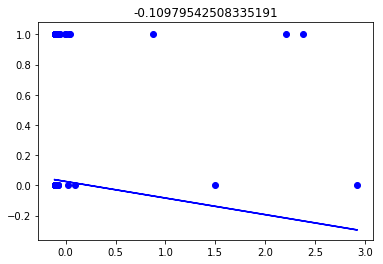

In [46]:
x = x_test4
y = y_test4
#line = matplotlib.lines.Line2D(clf4.coef_, clf4.intercept_)
plt.scatter(x, y, c='b')
slope = clf4.coef_[0][0]
intercept = clf4.intercept_[0]
print(slope, intercept)

# Create a list of values in the best fit line
abline_values = [slope * i + intercept for i in x]
# Plot the best fit line over the actual values
plt.plot(x, abline_values, 'b')
plt.title(slope)
plt.show()

### Neural Network 

#### Model

#### Analysis

### Conclusion